In [32]:
import tensorflow as tf
import tensorflow_datasets as tfds

tfk = tf.keras

import numpy as np
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

# Getting and preprocessing dataset

In [114]:
tf.random.set_seed(0)

num_articles = 10

dataset = tfds.load(name="cnn_dailymail", split=tfds.Split.ALL)
dataset = dataset.shuffle(buffer_size=512).repeat()
dataset = dataset.batch(num_articles)

nltk.download('stopwords')
stop_words = [word.replace("'", "").encode('utf-8') for word in stopwords.words('english')]

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/stratis/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [115]:
for example in dataset.take(1):
    
    # Dowload all articles and remove punctuation
    articles = tf.strings.regex_replace(example['article'],
                                        tf.constant("[[:punct:]]"),
                                        tf.constant(""),
                                        replace_global=True)
    
    # Split articles into words
    words = tf.strings.split(articles)
    
    # Count occurences of unique words
    unique, idx, counts = tf.unique_with_counts(words.values)
    
    vocab_dict = dict(zip(unique.numpy(), np.arange(len(unique))))
    vocab = tf.gather(unique, tf.where(counts > 1)).numpy()[:, 0]
    
    def get_word_mask(tensor):
        
        if len(tensor.shape) > 1:
            return tf.ragged.map_flat_values(get_rare_word_mask, tensor)

        else:
            return tf.map_fn(lambda x : str(int(x in vocab and not (x in stop_words))), tensor)
    
    def indexify(tensor):

        if len(tensor.shape) > 1:
            return tf.ragged.map_flat_values(indexify, tensor)

        else:
            return tf.map_fn(lambda x : str(vocab_dict[x.numpy()]), tensor)
    
    word_mask = tf.ragged.map_flat_values(get_word_mask, words)
    word_mask = tf.strings.to_number(word_mask, out_type=np.int32)
    word_mask = tf.cast(word_mask, dtype=tf.bool)
    
    words = tf.ragged.boolean_mask(words, word_mask)
    words = tf.ragged.map_flat_values(indexify, words)
    words = tf.strings.to_number(words, out_type=tf.int32)

In [116]:
def digamma(input_tensor, gradient=False):
    
    if gradient:
        
        output_tensor = None
        
        with tf.GradientTape() as tape:
            
            tape.watch(input_tensor)
            
            output_tensor = tf.math.digamma(input_tensor)
            
        return tape.gradient(output_tensor, input_tensor)
    
    else:
        return tf.math.digamma(input_tensor)

# Model

In [132]:
class LDA:
    
    def __init__(self, data, num_topics):
        
        self.data = data
        
        self.K = num_topics
        self.D = self.data.shape[0]
        self.V = len(tf.unique(words.values).y)
        
        self.words = [tf.one_hot(row, self.V, dtype=tf.float64) for row in data]
        
        # Model parameters
        self.alpha = 5.0 + 0.1 * tf.random.uniform(shape=(self.K,), dtype=tf.float64)
        self.eta = tf.Variable(5.0, dtype=tf.float64)
        
        # Variational posterior parameters
        self.lamda = tf.Variable(np.ones(shape=(self.K, self.V)))
        self.gamma = [np.ones(shape=(self.K,)) for d in range(self.D)]
        self.phi = [tf.ones(shape=(words_d.shape[0], self.K), dtype=tf.float64) / self.K for words_d in words]
        
    
    def single_variational_parameter_update(self):
        
        # Update gamma
        self.gamma = [(self.alpha + tf.reduce_sum(phi_d, axis=0)) for phi_d in self.phi]
        
        # Update lamda
        tmp = tf.stack([tf.matmul(tf.transpose(self.phi[d]), self.words[d]) for d in range(self.D)], axis=0)
        self.lamda = self.eta + tf.reduce_sum(tmp, axis=0)
        
        # Update phi
        digamma_lamda = digamma(self.lamda) - digamma(tf.reduce_sum(self.lamda, axis=-1, keepdims=True))
        words_digamma_lamda = [tf.matmul(self.words[d], tf.transpose(digamma_lamda)) for d in range(self.D)]
        
        digamma_gamma = [digamma(self.gamma[d]) - \
                         digamma(tf.reduce_sum(self.gamma[d], axis=-1, keepdims=True)) for d in range(self.D)]
        
        self.phi = [tf.exp(words_digamma_lamda[d] + digamma_gamma[d]) for d in range(self.D)]
        self.phi = [phi_d / tf.reduce_sum(phi_d, axis=-1, keepdims=True) for phi_d in self.phi]
        
        
    def single_model_parameter_step(self, eta_step, alpha_step):
        
        # Compute gradient, hessian and delta for eta
        digamma_lamda = digamma(self.lamda) - digamma(tf.reduce_sum(self.lamda, axis=-1, keepdims=True))
        
        dF_deta = self.K * (self.V * digamma(self.V * self.eta) - self.V * digamma(self.eta))
        dF_deta = dF_deta + tf.reduce_sum(digamma_lamda)
        
        # d2F_deta2 = self.K * (self.V ** 2 * digamma(self.V * self.eta, True) - self.V * digamma(self.eta, True))
        
        # delta_eta = - dF_deta / d2F_deta2
        
        # Compute gradient, hessian and delta for alpha
        digamma_alpha = digamma(self.alpha) - digamma(tf.reduce_sum(self.alpha))
        digamma_gamma = [digamma(gamma_d) - digamma(tf.reduce_sum(gamma_d, axis=-1, keepdims=True))
                         for gamma_d in self.gamma]
        
        dF_dalpha = self.D * digamma_alpha + tf.reduce_sum(digamma_gamma, axis=0)
        
        self.eta = self.eta + step_size * dF_deta
        self.alpha = self.alpha + step_size * dF_dalpha

In [133]:
lda = LDA(data=words, num_topics=5)
print(lda.alpha)

tf.Tensor([5.0424886  5.0778147  5.02899371 5.09664198 5.03069752], shape=(5,), dtype=float64)


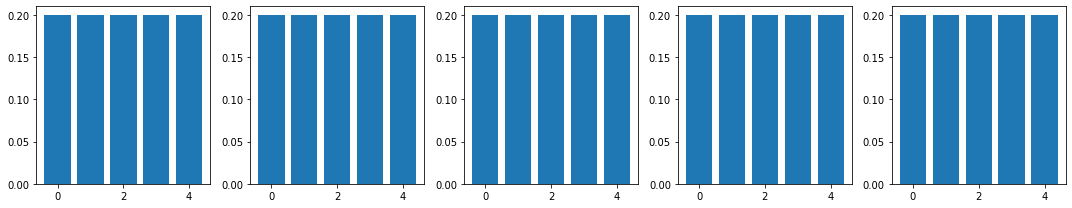

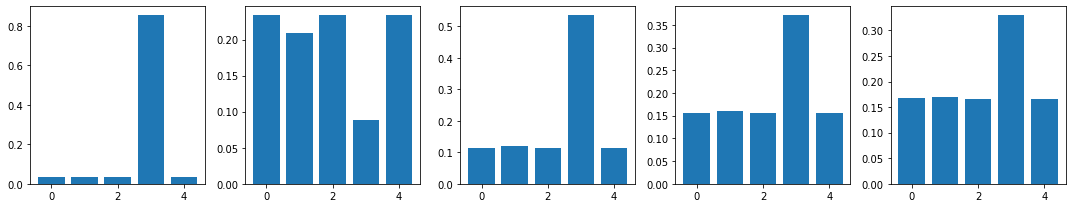

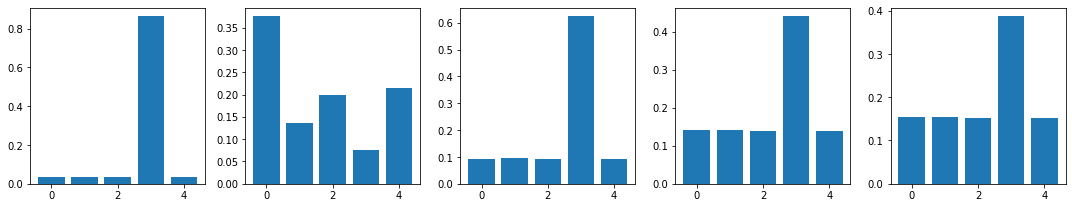

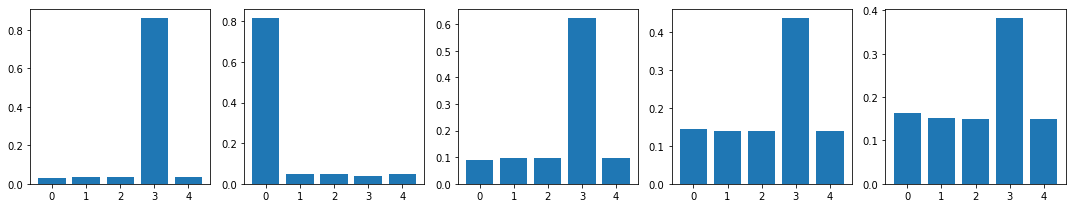

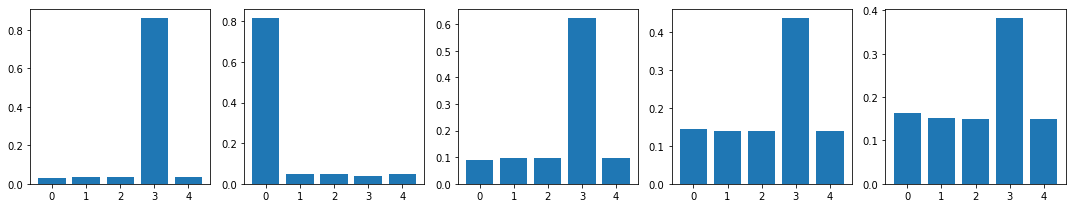

In [134]:
for i in range(500):
    
    if i % 100 == 0:
        
        plt.figure(figsize=(15, 3))
        
        for d in range(5):
            plt.subplot(1, 5, d + 1)
            plt.bar(np.arange(len(lda.phi[d][20])), lda.phi[d][20])
            
        plt.tight_layout()
        
        plt.show()
    
    lda.single_variational_parameter_update()

In [156]:
lda = LDA(data=words, num_topics=3)
print(lda.alpha)

tf.Tensor([1.21287182 1.63302889 1.82901434], shape=(3,), dtype=float64)


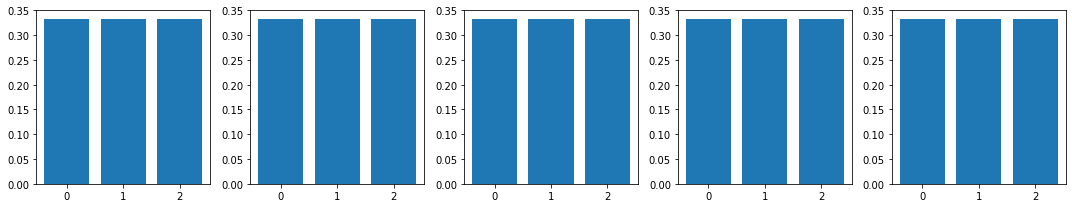

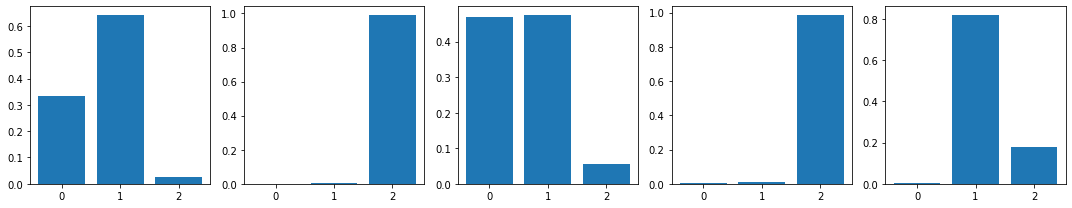

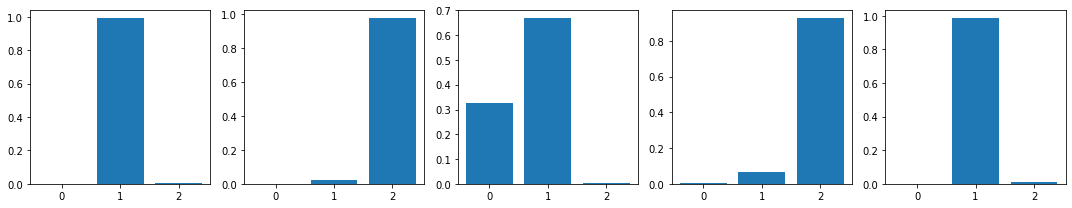

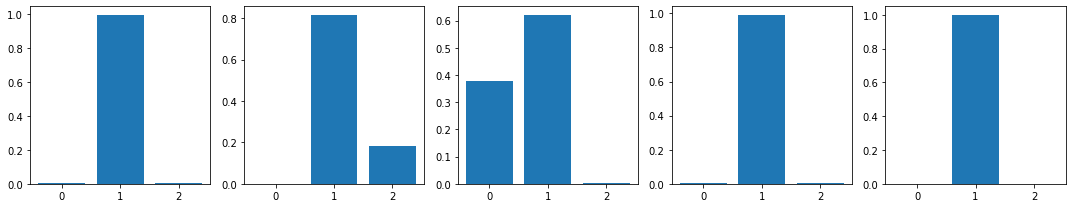

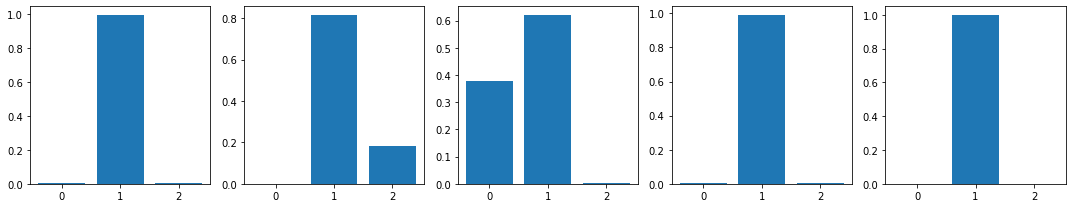

In [157]:
for i in range(500):
    
    if i % 100 == 0:
        
        plt.figure(figsize=(15, 3))
        
        for d in range(5):
            plt.subplot(1, 5, d + 1)
            plt.bar(np.arange(len(lda.phi[d][20])), lda.phi[d][20])
            
        plt.tight_layout()
        
        plt.show()
    
    lda.single_variational_parameter_update()

In [162]:
articles[0]

<tf.Tensor: id=12859942, shape=(), dtype=string, numpy=b'los angeles cnn  andrew dice clay one of the hottest and most controversial comedians two decades ago sits on his front porch late at night plotting his comeback i was almost like selfexiled from the business you know other than going out and making a living for myself i wasnt really making any career moves clay says talking with fellow comedian tom green i was bringing up my family green who was on celebrity apprentice with diceman in 2009 had his camera rolling when clay invited cnn to hang with him a recent friday night  just days before his first television comedy special in 17 years airs on showtime i want to be able to make people laugh as hard as they possibly can and i really think they need that dice said his tv special premieres at 10 pm new years eve so people can just have a couple of drinks and just laugh until it hurts clay rose to iconic status in the 1980s selling out hundreds of large arenas  including new yorks 